> **Quick note regarding runtime**  
> I've tried limiting the number of iterations and target losses in such a way that running this notebook in Google Colab will take a reasonable amount of time.  
> At roughly 3.3 it/s on Google Colab's CPU, running all cells in this notebook sequentially will take roughly 11 minutes.  
> By contrast, on a modern 12-core laptop CPU using JupyterLab it takes 80 seconds to run every cell here sequentially.  
>
> While the termination constants can be tweaked further to reduce runtime even more, it might result in the models looking worse than they deserve.  
> If, on the other hand, you are going to run this notebook locally on a modern-ish system, I strongly encourage you to give the models a bit more room to breath.  
> Of course if you're not too interested in experimenting with things you are already very familiar with, the current settings are more than good enough for demonstration purposes.

# Preperations
This part is dedicated to imports, initializations and other things that are relevant to the entire assignment.

In [1]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

In [2]:
# constants

# Termination constants
ITERATION_LIMIT = 1000 # Limit to number of allowed epochs
ACCEPTABLE_LOSS = 0.01 # Stop training below this in-sample loss (optimistic!)
ACCEPTABLE_CROSS_ENTROPY=0.25 # Stop training below this cross entropy loss
POCKET_ITERATION_LIMIT = 150 # Stop training if pocket is unchanged for this long
GRADIENT_THRESHOLD = 20 # stop training if gradient norm falls below this value

# Other Constants
ETA = 0.00002 # Default training rate for Softmax regression
TQDM_FORMAT = "{desc} - iteration: {n} - {rate_fmt} - {elapsed}"
EPSILON = np.finfo(np.float32).eps # below this a value is "basically 0"
# Set as numpy's internal eps value for float32, which is what we use here.

In [3]:
# general functions

# confusion matrix  
def inference_confusion_matrix(w, x, y):
    """Display a table detailing the model's performance.
    """
    table = {"correct classifications": [0]*11,
            "incorrect classifications": [0]*11,
             "accuracy": [0]*11,
            "sensitivity": [0]*11,
            "selectivity": [0]*11,
            "number of samples": [0]*11}
    TP, TN, FP, FN = [0]*10, [0]*10, [0]*10, [0]*10

    
    predictions = x @ w.T
    predictions = np.eye(10)[predictions.argmax(axis=1)] # convert to one-hot

    for i in range(10):
        class_predictions, class_labels = predictions[:, i], y[:, i] 
        TP[i] = np.sum((class_predictions == 1) & (class_labels == 1))
        TN[i] = np.sum((class_predictions == 0) & (class_labels == 0))
        FP[i] = np.sum((class_predictions == 1) & (class_labels == 0))
        FN[i] = np.sum((class_predictions == 0) & (class_labels == 1))
        table['correct classifications'][i] = TP[i] + TN[i]
        table['correct classifications'][10] += TP[i] + TN[i]
        table['incorrect classifications'][i] = FP[i] + FN[i]
        table['incorrect classifications'][10] += FP[i] + FN[i]
        table['accuracy'][i] = (TP[i] + TN[i]) / (TP[i] + TN[i] + FP[i] + FN[i])
        table['sensitivity'][i] = TP[i] / (TP[i] + FN[i]) 
        table['selectivity'][i] = TN[i] / (TN[i] + FP[i])
        table['number of samples'][i] = np.sum(class_labels)

    table['accuracy'][10] = (table['correct classifications'][10] / 
                            (table['correct classifications'][10] + 
                            table['incorrect classifications'][10]))
    table['sensitivity'][10] = sum(TP) / (sum(TP) + sum(FN))
    table['selectivity'][10] = sum(TN) / (sum(TN) + sum(FP))
    table['number of samples'][10] = sum(table['number of samples'][:10])
        
    output = pd.DataFrame.from_dict(table, orient='index',
                                    columns=['0','1','2','3','4',
                                            '5','6','7','8','9',"Total"])

    # It took me an embarassingly long time to figure out how to stop ints
    # from showing trailing zeros
    rows_to_make_ints = ['correct classifications', 'incorrect classifications', 'number of samples']
    output = (output.style.format("{:.0f}", subset=pd.IndexSlice[rows_to_make_ints, :]))
    
    return output

# display plot 
def show_plot(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    for i in range(10):
        plt.plot([vec[i] for vec in data], label=f"Class {i}")
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# heat map
def show_diff_heatmap(data1, data2, label):
    plt.figure(figsize=(15,6))
    diff_data = data1.data - data2.data
    heat = sns.heatmap(diff_data, annot=True, fmt='.4f', center=0, 
                       cmap='coolwarm')
    heat.collections[0].colorbar.set_label(label)
    plt.tight_layout()
    plt.show()

In [4]:
# fetch the dataset
mnist = fetch_openml('mnist_784', version=1)

In [5]:
# Initialize data

# split dataset into x (features) and y (labels)
x, y = mnist["data"], mnist["target"]
# split x and y into training sets and test sets
# (training set is made up of 60,000 entries and test set has 10,000 entries)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000)
# convert labels from strings to integers (for later ease of use)
y_train, y_test = y_train.astype(int), y_test.astype(int)
# convert data from strings to np.float32 (so we can use them for calculations)
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Convert labels into One-Hot vector representation
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]
# Normalize x_train and x_test values
x_train, x_test = x_train / 255.0, x_test / 255.0
# Apply the bias trick on x_train and x_test
ones_test, ones_train = np.ones((x_test.shape[0],1)), np.ones((x_train.shape[0],1))
x_train, x_test = np.hstack((ones_train, x_train)), np.hstack((ones_test, x_test))

### Explanation - conversion into One-Hot Vector Representation

After fetching and splitting the labels into `y_train` and `y_test`, they exist in the form of an array with 2 columns where each row represents an entry in the dataset.
The left column represents the index of an example and the right column represents the label, which is of course an integer from 0 to 9.  
Now we want to convert this representation into a *One-Hot Vector Representation*.  
Or more accurately, we want to transform each given entry in the array into a vector where every element is 0 except for the index whose value equals the label value, where it will receive a value of 1.  
We also want to represent all these labels in one matrix.  
(A vector of vectors, in a sense)  

To do that we will use *the identity matrix* (as implemented in NumPy) and *advanced indexing*.  

Calling the method `np.eye(n)` will produce an $n \times n$ identity matrix.  
Meaning, calling `np.eye(10)` will produce the identity matrix $I_{10}$.  
It's obvious that for each index $i$, the $i$-th row of $I_{10}$ is the One-Hot vector representation of the label $i$.  
(We choose $n = 10$ because there are 10 labels total)

We then use advanced indexing on $I_{10}$ with `y_train` and `y_test` to create a $10 \times 60,000$ and $10 \times 10,000$ matrix respectively that is a matrix representation of the labels in one-hot vector representation.  
That is, if the $i$-th label is of value $\alpha$ than the row in the final matrix representing that label will be a vector where all values are 0 except for the $\alpha$-th value, which will be 1.

# Part A: Perceptron Learning Algorithm


## Description of the multi-class perceptron algorithm

### Overview of Perceptron-Derivation for a single class

As we saw in the lectures, the classic perceptron-derivation algorithm is as follows: 
1. Start with $w(t)$, $x$ and $y$ as input.  
   ($y$ is transformed from a one-hot vector representation to one where all 0s are replaced with -1)  
2. For each sample $x_n$, let $s_n = \text{Sign} \left( \left( w(t) \right) ^T x_t \right)$ be the *prediction*.
3. if $s_n \neq y_n$ (that is, if the prediction classifies the sample incorrectly), update the new weights to be $w(t+1)=w(t) + y_t \cdot x_t$

We can improve the performance of this algorithm by calculating the changes to the next weights simultaneously instead of one-by-one.  
We can do this by simply getting the dot product of $x$ and $\left( w(t) \right) ^T$ and applying $\text{Sign}$ to it, which will give us a vector of predictions for each sample.  
Then for eveyr element in this matrix that is different from the corresponding element in $y$, we will perform the adjustments on the weights.

### Adjusting the Perceptron-Derivation algorithm to a multi-class scenario

We are tasked with solving a multi-class classification problem using Perceptron-Derivation, for that we need to come up with an updated algorithm.  
The naive approach would be to break up $y$ and $w$ by class, performing the above algorithm on each of them simultaneously and then concatenating the output back out.  
This would involve the use of for loops, which are not only slow but could also almost-always be replaced by a matrix which does the exact same, so let's try doing that.  

We start with $x$ as before and $y$ and $w$ in their *full* form.  
Meaning, we don't just get the predictions and weights for one class, we get them for ALL classes at once.  

We'll start with the dot product $x \cdot \left( w(t) \right) ^T$ which we will name $p$. (as in ***p**rediction*)  
In this matrix, the element at row $i$ and column $j$ will represent the application of the weights for class $j$ on sample $x_i$.  
Specifically, each row represents the classification of $x_\text{row}$ into the 10 classes and each column represents the classification the samples into the class of the same index.  
In the inference phase we're told we need to return the classification with the highest *confidence*, meaning applying $\text{Sign}$ on each element won't cut it like it did before,  
Since we can end up in a situation where two elements in a row are positive, (meaning a sample belongs to two digits, which makes no sense) or even a row with no positive values at all.  
For that reason we can select the index of the maximum value at each row (`np.argmax`) and get a vector of labels representing the classification with the highest confidence.  
We can then very easily convert it back into a one-hot vector representation, which will be very useful soon.  

We now have two matrices of identical shape, $y$ and $p$.  
Our next step is to adjust the weights for every misclassified example.  
It's easy to see that if sample $x_n$ is properly classified than the $n$th rows in $y$ and $p$ will be identical.  
Therefor, by subtracting $p$ from $y$ we'll get a matrix where if the entire row is filled with zeros, this sample is *correctly classified*, and if it is *incorrectly classified* it will have a row that is made up of one $1$ (representing the correct classification),  
one $-1$ (representing the incorrect classification) and zeros in all the other values.  
In other words, the matrix $y-p$ tells us which samples need to influence which weights and how.  
So the value $(y-p)[i][j]$ represents how sample $x_i$ needs to influence weights $j$, if at all. 
So if that value is 0, not at all, if it's 1 we should add $x_i$ to $w_j$ and if it's -1 we should subtract $x_i$ from $w_j$.  

This once again sounds an awful lot like a for loop, which means there's a good chance there's a matrix that can perform the equivalent operation.  
Specifically, we want to turn $x$ and $y-p$ into an `update` matrix, so that $w(t+1) = w(t) + \text{update}$.  
To do that we can simply get the dot product of $p^T \cdot x$, each row of this product will be exactly the change we want to make to the current weights to get the new weights.

## Step-by-Step Algorithm Description

### Training phase

1. Initialize `w` (weights) and `pocket_w` (pocket weights) to 0
2. Generate new weights:
   1. Get new `prediction` matrix: (past the first iteration this will be given as input rather than re-generated)
       1. calculate `x @ w.T`
       2. get `np.argmax` for each row in `x @ w.T`, resulting in a vector of predicted classifications
       3. convert the vector we got in step b to a one-hot vector representation using advance indexing on the identity matrix $I_{10}$
       4. Subtract the matrix we got in step c from y and return the result
   2. Calculate `prediction.T @ x` to get `updates`
   3. return `w + updates`
3. Pre-calculate `prediction` for the new weights, as these will be used both by the $E_{in}$ function as well as the next time we get new weights.
4. Get in-sample `error` for each class as well as in general (`total_error`).  
   (The in-sample error for each individual class will be stored in an array to later present it in a graph)
5. if `total_error < pocket_error`: (If the current weights have lower $E_{in}$ than the pocket weights)  
    1. set `pocket_w` $\leftarrow$ `w`
    2. set `pocket_error` $\leftarrow$ `total_error`
    3. set `pocket_iteration` (the epoch in which the current pocket weights have been set) to the current iteration
6. Return the pocket weights (as well as the per-class in-sample error history) once a termination condition has been reached

### Termination conditions
1. `ITERATION_LIMIT` - if we have reached the iteration limit as set in the beginning
2. `POCKET_ITERATION_LIMIT` - If we have gone through a predefined number of epochs without changing the pocket weights
3. `ACCEPTABLE_LOSS` - If the $E_{in}$ value in the current pocket weights is below a predefined threshold

### Inference phase
1. We start with a sample vector $x_n$ and the weights we got from the training phase $w$.
2. get dot product `x @ w.T`, and select the index of the highest value. (highest confidence score)
3. The index we found above is the predicted classification of $x_n$

## Implementation

In [6]:
def get_perceptron_prediction(w, x, y):
    "get a matrix representing which samples should influence the next weights and how"
    prediction = np.eye(10)[np.argmax(x @ w.T, axis=1)]
    return y - prediction

def new_perceptron_weights(w, x, y, pred=None):
    """ Get the next iteration of weights via the perceptron algorithm.

    Arguments:
    w -- current weights
    x -- data 
    y -- labels in one-hot vector representation
    pred -- the output of get_perceptron_prediction for the same input.  
            Can be used to avoid unnecessary recalculations
    """
    if pred is None: 
        pred = get_perceptron_prediction(w,x,y) 
        
    # for each class, update the corresponding weights
    updates = pred.T @ x

    return w + updates

def in_sample_error_perceptron(w, x, y, pred=None):
    """ Get the in-sample error.

    Arguments:
    w -- current weights
    x -- data 
    y -- labels in one-hot vector representation
    pred -- the output of get_perceptron_prediction for the same input.  
            Can be used to avoid unnecessary recalculations

    Returns: (class_error_list, total_error) 
    class_error_list - a list of in-sample error values, where value i 
                       represents the in-sample error for class i.
    """ 
    if pred is None:
        get_perceptron_prediction(w, x,y)

    bad_pred_per_class = np.sum(pred != 0, axis=0)
    # Normalize for sample size 
    bad_pred_per_class = bad_pred_per_class / y.shape[0]
    total_errors = np.sum(bad_pred_per_class)
    return bad_pred_per_class, total_errors
    
def multiclass_perceptron_train(x, y):
    """Train the model to distinguish between digits 0 to 9.

    Arguments:
    x -- data
    y -- labels in one-hot vector representation

    Returns: (pocket_w, error_history) 
    pocket_w -- The output weights for the trained model
    error_history -- list of lists, can be plugged into a plot to see change 
                     of in-sample value for every class.
    """
    # initialization
    pocket_iteration = 0
    # pocket_error = np.full((10,), 1) # initialize pocket error to all 1's
    pocket_error = 1
    w = np.zeros((10, 785))
    pocket_w = np.zeros((10, 785))
    error_history = [] # initialize a list of class errors which will
                       # later be used to draw a plot
    pred = None
    
    # Training
    prog = trange(ITERATION_LIMIT, bar_format=TQDM_FORMAT) 
    for i in prog:
        w = new_perceptron_weights(w,x,y,pred) # new weights
        # prepare new prediction, as it will be used both for the in-sample 
        # error in this epoch and the new weights function in the next.
        pred = get_perceptron_prediction(w,x,y)
        # in-sample error for new weights
        error_by_class, total_error = in_sample_error_perceptron(w,x,y,pred)
        error_history.append(error_by_class)

        # Check if the current weights are an improvement over the pocket
        if (pocket_error > total_error): 
            pocket_error = total_error
            pocket_w = w
            pocket_iteration = i
            prog.set_description_str(f"pocket error: {pocket_error:.4f}")
            # check if the pocket error is below the termination threshold
            if pocket_error <= ACCEPTABLE_LOSS: 
                print("Run stopped after reaching acceptable loss")
                break

        if (i - pocket_iteration >= POCKET_ITERATION_LIMIT): 
            print(f"run stopped after {POCKET_ITERATION_LIMIT} " + 
                  "iterations without change to the pocket weights")
            break 

    return pocket_w, error_history

## Testing

In [7]:
weights_perceptron, errors_perceptron = multiclass_perceptron_train(x_train, y_train)

 - iteration: 0 - ?it/s - 00:00

run stopped after 150 iterations without change to the pocket weights


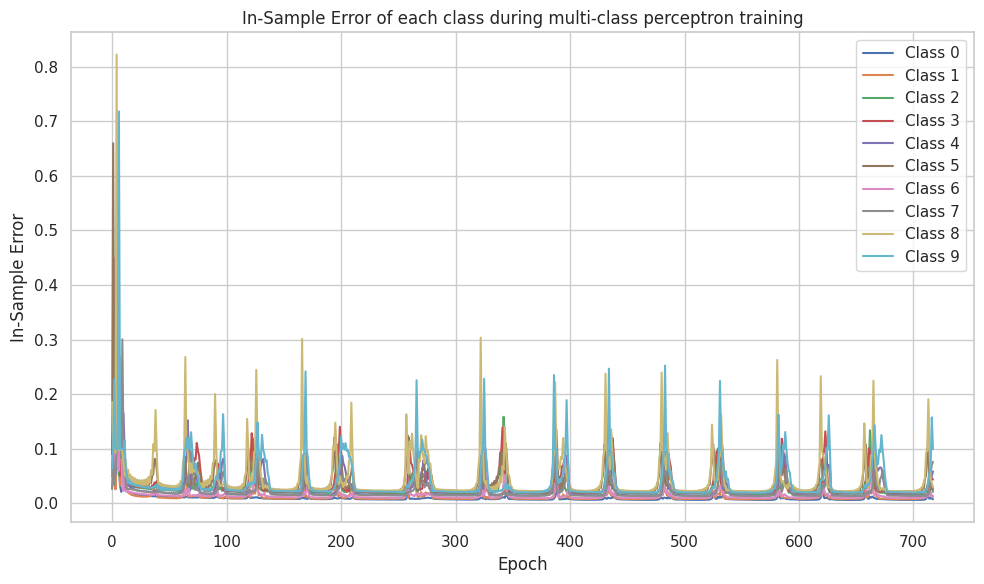

In [8]:
show_plot(errors_perceptron, 
          "In-Sample Error of each class during multi-class perceptron training", 
          "In-Sample Error")

In [9]:
perceptron_confusion = inference_confusion_matrix(weights_perceptron,
                                                  x_test, y_test)
perceptron_confusion

,0,1,2,3,4,5,6,7,8,9,Total
correct classifications,9912,9915,9788,9781,9850,9751,9899,9809,9744,9755,98204
incorrect classifications,88,85,212,219,150,249,101,191,256,245,1796
accuracy,0.991200,0.991500,0.978800,0.978100,0.985000,0.975100,0.989900,0.980900,0.974400,0.975500,0.982040
sensitivity,0.948079,0.960360,0.897059,0.897160,0.940625,0.859873,0.947746,0.913534,0.866242,0.864271,0.910200
selectivity,0.995795,0.995388,0.988085,0.987304,0.989712,0.987083,0.994459,0.988921,0.985648,0.987886,0.990022
number of samples,963,1110,1020,1021,960,942,976,1064,942,1002,10000


## Conclusions for Part A

### Linear separability 
As we can see in the plot above, we do not get a neat convergence, but instead we get spikes where the algorithm "screws up" and has to compensate for its own mistakes.  
We would not expect this behavior from data which is linearly separable, instead what we'd expect is a steady improvement at every epoch until we reach a point where no changes are made to the weights.  
This suggests that the data **is not linearly separable**.

### Output accuracy
Even when limiting this model to relatively few epochs, we get a fantastic overall accuracy of over 98%.

We can also see a nice correlation between in-sample error for each classifier and accuracy for the test data,  
which suggests the training phase was done properly.

One particularly interesting observation is that some classifiers are "luckier" than others.  
Some classifiers, like those for `1` and `2`, consistently get the highest accuracy scores of the classes.  
By contrast, the classifiers for `5`, `8` and `9` are consistently poorer than their peers.  
That *might* suggest that the classification problem for some digits is closer to being linearly-separable than it is for others.  
(Meaning, the better a class performs the fewer outliers in this linear separation)

### Differences in sensitivity and similarity in selectivity
Speaking of the "easier" and "harder" classes, we can see that the big difference between those two groups is in **sensitivity**,  
Whereas selectivity seems to be very similar across all classes.  
This suggests that it's much easier to determine "*This is not an 8*" than it is to determine "*This is an 8*".  

One explanation that comes to mind is that our "troublemaker" classes belong to digits which look similar to one another.    
So if we were to combine them into a single class we'd get a fantastically accurate model, assuming not being able to tell 3, 5, 8 and 9 apart fits someone's usecase.  

A far less exciting explanation is that any model which has to choose one of 10 classes for a sample will get at least 8 of them right.  
Meaning that even completely random assignments would yield selectivity scores of no less than 80%.

# Part B: Softmax Regression

In this part we will implement *Softmax Regression* on the same dataset.  
This model will be similar to the Perceptron model we implemented in part A.  
In this model, just like in part A, we will train 10 classifiers, one for each digit.  
Then for a given example we will have each classifier decide if it belongs in its class or not.  
Then we return the answer with the highest confidence.

Unlike the Perceptron, each classifier will be implemented using **Gradient Descent**.

## Step-by-step algorithm description

This is a broad outline of the algorithm as we will implement it.  
In this part we assume we train for each class separately, however in practice we will train for all classes at once.  
This simultaneous training algorithm will be shown later.

### Training phase
1. Initialize the weights to $\underline{0}$
2. Calculate $E_{in}(w(t))$ for the current weights.
3. Calculate the gradient - $g_t = \nabla E_{in}(w(t))$
5. update the weights - $w(t+1) = w(t) + \eta v_t = w(t) - \eta g_t$
6. Check if any of the termination conditions are met
    1. If at least one termination condition is met, stop and return the weights.
    2. Otherwise return to step 2 using the new weights $w(t+1)$


### Termination conditions
The above loop will stop as soon as at least one of the following conditions are met.
1. Iteration limit reached. (`i >= ITERATION_LIMIT`)
2. In-sample error falls below some threshold. (`error < ACCEPTABLE_LOSS`)
3. The norm of the gradient falls below some threshold. ($||\nabla E_{in} || <$ `GRADIENT_THRESHOLD`)

### Inference phase
1. Create a vector of size 10 where the $i$-th element is equal to $e^{(w^{(i)})^T x}$  
   That is, the exponent of $(w^{(i)})^T x$.  
   ($x$ is the feature vector and $w ^{(i)}$ is the weights for classifier $i$)
2. Normalize this vector by multiplying each element by $\frac{1}{\sum_{j=1}^K \exp \left( (w^{(j)})^T x \right)}$  
   What we have now is a vector of probabilities.  
   That is, the $i$-th element contains the probability that the given example $x$ is a representation of the digit $i$.
3. Select the index of the value in the vector which has the highest value (argmax) and return it as the output.

## Computing the gradient function

### Breaking up the cost function

The equation for $E_{in}(w)$ as given to us in the assignment is fairly straightforward for the purpose of calculating the in-sample loss.  
However, it is not immediately clear what the gradient function should look like.  
For that reason we have find the function for $\nabla _{w_k} E_{in}w$ by hand.  

We will start by breaking up $E_{in}$ into more manageable expressions. We start with the following function:

$$E_{in}(w) = - \sum_{n=1}^N \sum_{k=1}^K \mathbb{I} \{ y_n = k \} \log \frac{e^{w_k ^T x_n}}{\sum _j e^{w_j ^T x_n}}$$  

We have an outer sum of $N$ elements, $N$ is the number of samples, so we're summing the result of an operation for each sample.  
Immediately after that we have a sum of K elements, we were told K is the number of classes, meaning $K=10$.  
So for each data sample we perform *some* operation for each class and sum the result.  
Next we have the expression $\mathbb{I} \{y_n = k \}$, that is the indicator function.  
Meaning, the following expression can be non-zero only if the label matches.  
**Meaning that for every sample (the outer loop) we only look at its predefined label**.  
So if the sample $x_i$ is labeled as belonging to class $y$, we will only perform the following for class $y$!  
Meaning we can already simplify the above equation to look like this:  
$$E_{in}(w) = - \sum _{n=1}^N \log \left( \frac{e^{{(w_{y_n})}^Tx_n}}{\sum _{k=1}^{10} e^{w_k^Tx_n}} \right) \qquad s.t \qquad x_n \text{ is labeled as belonging to class } y_n$$  

Now let's look at the fraction.  
From the rules of logarithmics we know that $\log \left( \frac{m}{n} \right) = \log(m) - \log(n)$, meaning $\log \left( \frac{e^{{(w_{y_n})}^Tx_n}}{\sum _{k=1}^{10} e^{w_k^Tx_n}} \right) = \log \left( e^{w_{y_n}^Tx_n} \right) - \log \left( \sum _{k=1}^{10} e^{w_k^Tx_n} \right)$  
In the context of *machine learning*, $\log$ almost always refers to *the natural logarithm*, meaning $\log \equiv \log_e \equiv \ln$, so that it how we will treat it.  
meaning that $\log \left( e^{w_{y_n}^Tx_n} \right) = \ln \left( e^{w_{y_n}^Tx_n} \right) = w_{y_n}^Tx_n$.  
(From here on out we will replace all mentions of $\log$ with $\ln$ for my own convenince, the ambiguity stalled me)

Now the equation looks like this:  
$$ E_{in}(w) = - \sum_{n=1}^N \left( w_{y_n}^Tx_n -\ln \left( \sum_{k=1}^{10} e^{w_k^Tx_n} \right) \right) = - \sum_{n=1}^N \left( w_{y_n}^Tx_n \right) + \sum_{n=1}^N \ln \left( \sum_{k=1}^{10} e^{w_k^Tx_n} \right)$$  

### Mathematically expressing the gradient

We now need to compute $\nabla _{w_k} E_{in}(w)$.  
In the previous section we managed to simplify $E_{in}$ to be:  
$$ E_{in}(w) = - \sum_{n=1}^N \left( w_{y_n}^Tx_n \right) + \sum_{n=1}^N \ln \left( \sum_{k=1}^{10} e^{w_k^Tx_n} \right)$$  
Now we need to find the derivative of each term.

We'll start with the first term.  
$$- \sum_{n=1}^N \left( w_{y_n}^Tx_n \right)$$
The term $w_k$ only exists in the term $w_{y_n}^Tx_n$ when $y_n = k$. Therefor
$$\nabla _{w_k} \left( -w_{y_n}^Tx_n \right) = \begin{cases} -x_n && y_n = k \\ 0 && \text{otherwise} \end{cases} \qquad \Rightarrow \qquad \nabla _{w_k} \left( - \sum _{n=1}^N \left( w_{y_n}^Tx_n \right) \right) = - \sum_{n=1}^N \nabla_{w_k} \left( w_{y_n}^Tx_n \right) = -x_n$$
This is fine when we know which class $x_n$ belongs to, but we need to put this expression back into the overall gradient.  
This would be confusing, so instead we'll say this term is equal to $(-1)\cdot \mathbb{I} \{ y_n = k \} \cdot x_n$.  
This will make sense later on.

Now for the second term.
$$\sum _{n=1}^N \ln \left( \sum_{k=1}^{10} e^{w_k^Tx_n} \right)$$
We'll define $S = \sum_{k=1}^{10} e^{w_k^Tx_n}$ and look at $\ln(S)$ first.  
Using the chain rule we find that $\nabla _{w_k} \ln(S) = \frac{1}{S} \cdot \nabla _{w_k}S$, that leaves us with this term:
$$\sum _{n=1}^N \left( \frac{\nabla _{w_k} \left( \sum_{l=1}^{10} e^{w_l^Tx_n} \right)}{\sum_{k=1}^{10} e^{w_k^Tx_n}} \right)$$

Now we just need to find $\nabla _{w_k} \left( \sum_{l=1}^{10} e^{w_l^Tx_n} \right) = \sum_{l=1}^{10} \left( \nabla _{w_k} \left( e^{w^T_lx_n} \right) \right)$.  
Similarly to the calculations we've done on the first term, we can see that when $l \neq k$ the term $w_k$ isn't part of the expression.  
Meaning that when $l \neq k$, $\nabla _{w_k} \left( e^{w^T_lx_n} \right) = 0$.  

However, when $l=k$ we can learn from the fact that $\frac{d}{dx}e^x = x\cdot e^x$ that $\nabla _{w_k} \left( e^{w^T_lx_n} \right) = e^{w_k^Tx_n}\cdot x_n$  
to summarize, we found that $\nabla _{wk} e^{w_l^Tx_n} = \begin{cases} 0 && l \neq k \\ e^{w_k^Tx_n}\cdot x_n && l = k \end{cases}$ and therefor
$$\nabla _{w_k} \left( \sum_{l=1}^{10} e^{w_l^Tx_n} \right) = e^{w_k^Tx_n}\cdot x_n$$

Now we've solved all the partial derivatives, now we'll try and make the second term look nicer
$$\sum _{n=1}^N \left( \frac{\nabla _{w_k} \left( \sum_{l=1}^{10} e^{w_l^Tx_n} \right)}{\sum_{k=1}^{10} e^{w_k^Tx_n}} \right) = \sum _{n=1}^N \left( \frac{e^{w_k^Tx_n}\cdot x_n}{\sum_{l=1}^{10} e^{w_l^Tx_n}} \right) = \sum _{n=1}^N \left( \frac{e^{w_k^Tx_n}}{\sum_{l=1}^{10} e^{w_l^Tx_n}} \cdot x_n \right)$$

Therefor, the gradient equation will be
$$\nabla _{w_k} E_{in}(w) = \sum _{n=1}^N \left( \frac{e^{w_k^Tx_n}}{\sum_{l=1}^{10} e^{w_l^Tx_n}} \cdot x_n - \mathbb{I}\{ y_n=k \}x_n \right)$$
We can see that the fraction is actually just the probability for $x_n$ to be classified into class $k$, so we can further simplify this expression like this:
$$\nabla _{w_k} E_{in}(w) =\sum_{n=1}^N \left( P(y=k | x_n) - \mathbb{I}\{y_n = k\} \right) \cdot x_n$$

And now, *finally*, this equation is friendly enough to turn into a step-by-step algorithm.  
We should keep in mind that this gradient is only for a single classifier, for the weights we currently observed.

## Translating the functions into algorithms

For every part of this section:
* **x** - The *data*
* **y** - The *labels* in one-hot vector representation
* **w** - The *weights*

### Softmax computation algorithm

The expression $\frac{e^{w_k^Tx_n}}{\sum _j e^{w_j^Tx_n}}$ is precisely _the softmax function_ for sample x_n in class k.  
Being the namesake of the entire algorithm, it is the cornerstone of both the $E_{in}$ calculation as wel as the $\nabla _{w_k}$ calculation.  
For that reason it's only fair to honor it by defining its own algorithm.  

Our goal is to get a **matrix** where each element represents the softmax for _a_ sample and _a_ class.  
1.  **get** `x @ w.T` - this will produce a patrix where each element represents $w_k^T w_n$.
2.  **Apply the exponent function on all elements** - now each element represents $e^{w_k^T w_n}$.
3.  **create a new matrix** representing the denominator expression, which we can get simply by summing the above matrix over the classes (axis=1)  
    This will naturally result in a vector.  
4.  **divide the matrix from step 2 by the denominators** such that the value in the denominator vector representing the sum of exponential softmax values for $x_n$ divides $x_n$.
5.  **return** the result

This matrix can now be used by either the in-sample loss algorithm or the gradient computation algorithm.

### in-sample loss computation algorithm

Having implemeneted the softmax algorithm above, the in-sample loss algorithm becomes very simple.

1. **get softmax matrix**
2. **element-wise multiply the softmax matrix by y** - this will have the same effect as multiplying each element by $\mathbb{I}\{y_n=k\}$
3. **select only the non-zero values and store them in a vector**   
   We do this for two reasons:
    1. Since in the end we are summing all rows and all vectors, it's the same as summing all values in the matrix regardless of position.  
       For that reason we can vectorize the matrix without losing any information.
    2. We must remove the values equal to 0 to avoid a math error in the next step.  
       In truth we are removing all values smaller than some very small constant `EPSILON`.  
       That is because float values have a nasty habit to be treated as 0 when they are small enough, so even a very small value can trigger a math error.
4. **Apply `log` (really $\ln$) on all values in the vector**
5. **Sum all values in the vector**
6. **Divide by the number of samples** by dividing the above value by the number of samples.  
   This step is not strictly speaking necessary, but it produces esoteric, high values.  
   The average loss 'per sample' is a lot more intuitive and a lot more in-line with the values we'd see in part A.
7. **Return** the value

### gradient computation algorithm - improved 

The equation we have found earlier represents the gradient for one class.  
In truth the calculations for any class' gradient are independent of one another and share many values.  
For that reason it would be a waste to do them independently and much more efficient to do them all at once.

1. **get softmax matrix**
2. **Subtract y from the matrix** - this is equivalent to subtracting $\mathbb{I}\{y_n = k \}$ only from the correct softmax values.
3. **return** the dot product of the above matrix with x, which is equivalent to multiplying a softmax derivative with the correct sample and then summing all these samples.

At the end of this process we are left with a matrix where each row represents the *gradient* for the class of the same value as its index.

### Dealing with overflow - The Log-Sum-Exp trick (LSE)

I originally implemented the rest of the code as is above, but I quickly ran into float overflow errors.  
Clearly the exponent on the values in my matrices produce very, very large values that we need to shrink.  
The immediate suspect is $\frac{e^{w_k^Tx_n}}{\sum_{l=1}^{10} e^{w_l^Tx_n}}$, so that's what we'll be focusing on, we'll also define $z_k = w_k^Tx_n$ for simplicity. 

We start with the term $\frac{e^{z_i}}{\sum _j e^x_j}$ and we want to minimize the terms $z_i$ and $z_j$ because the exponent function grows very rapidly.  
It's also important that whatever change we make doesn't change the value of this expression! otherwise it no longer represents the same thing.
For that we'll use a trick called *Log-Sum-Exp*, or *LSE* for short.

First we'll notice that for any $a \in \mathbb{R}$ we'll get $$\frac{e^{z_i}}{\sum _j e^{x_j}} = \frac{e^a \cdot e^{z_i}}{e^a \cdot \sum _j e^{x_j}} = \frac{e^a \cdot e^{z_i}}{\sum _j e^a \cdot e^{x_j}} = \frac{e^{z_i + a}}{\sum _j e^{x_j + a}}$$  
This means that we can add or subtract any value we like from the powers so long as we add or subtract the same value in the numerator's and the denominator's powers.  
Now the trick is choosing a value $a$ for which $e^a$ never overflows.  
We can guarantee that if we choose $a$ to be less-than-or-equal to 0, since $e^0 = 1$ and for $a < 0$ we get $e^a = \frac{1}{e^{-a}}$ and $0 \leq \frac{1}{e^{-a}} \leq 1$  
If we choose $a = \underset{j}{\max} (z_j)$ we'll guarantee that not only will $z_j - a \leq 0$ for every $j \in \{0, 1, \dots, 9\}$, 
but that every such value will also be greater than $-a$.

By baking LSE into the softmax matrix algorithm we can essentially implement it in both the in-sample error algorithm and the gradient algorithm.  
Thus solving the overflow problem.  

(As mentioned previously, we also avoid underflow by treating very small float values as zero)

## Implementation

In [10]:
def get_LSE_offset(x):
    "Return the offset necessary to apply the LSE trick"
    output = np.max(x, axis=1)
    return output[:, np.newaxis]

def get_next_softmax_weights(weights, gradients, eta=ETA):
    "Return the next iteration of weights according to softmax regression"
    return weights - (eta * gradients)

def vector_norm(x):
    """Get the norm of each row vector in the input.

    Return: list of values, the i-th element is the norm of the i-th row vector
    """
    output = np.sqrt(np.sum(np.square(x), axis=1))
    return output

In [11]:
def get_softmax_matrix(w,x,y):
    """ Return a matrix where the value in row r and column c is the softmax
    value for class r and sample c.

    Arguments:
    w -- current weights
    x -- data
    y -- labels in one-hot vector representation
    """
    numerators = x @ w.T
    offset = get_LSE_offset(numerators)
    numerators = numerators - offset
    numerators = np.exp(numerators)
    denominators = np.sum(numerators, axis=1, keepdims=True)
    return numerators / denominators

def get_softmax_gradients(x, y, softmax):
    """ Return a matrix where the i-th row is the gradient for class i

    Arguments:
    x -- data
    y -- labels in one-hot vector representation
    softmax -- softmax matrix - as generated by get_softmax_matrix
    """ 
    softmax_subtracted = softmax - y 
    return softmax_subtracted.T @ x

def get_in_sample_error_softmax(y, softmax):
    """ Return the in-sample error, normalized for number of samples.

    Arguments:
    y -- labels in one-hot vector representation
    softmax -- softmax matrix - as generated by get_softmax_matrix
    """ 
    inner_expression = softmax * y 
    # Remove all values smaller than some very small constant to avoid
    # math errors while applying log
    inner_expression = inner_expression[inner_expression > EPSILON].flatten()
    inner_expression = np.log(inner_expression)
    # normalize to sample size
    return (np.sum(inner_expression) * (-1)) / y.shape[0]
    

In [12]:
def softmax_train(x, y, eta=ETA, iteration_limit=ITERATION_LIMIT):
    """ Generate weights for a softmax-regression-trained integer classifier
    Also returns a list of gradient norm values over epochs

    Arguments:
    x - data
    y - labels in one-hot vector representation
    eta - (optional) learning rate, defaults to 0.01
    iteration_limit - (optional) maximum epoch count, defaults to 10000
    """
    # Initializations
    w = np.zeros((10,785)) # initialize starting weights to be zero
    prog = trange(iteration_limit, bar_format=TQDM_FORMAT)
    grad_norms = list() # gradient norms history will be saved for later plotting
    error = 0
    
    for i in prog:
        # training
        softmax = get_softmax_matrix(w,x,y) 
        grads = get_softmax_gradients(x,y,softmax) 
        w = get_next_softmax_weights(w, grads, eta)

        # keeping records of the run 
        grad_norms.append(vector_norm(grads))
        
        # update progress only every 10th iteration
        if i % 10 == 0:
            error = get_in_sample_error_softmax(y, softmax)
            prog.set_description_str(f"in-sample error: {error:.4f}")
            if error < ACCEPTABLE_CROSS_ENTROPY: # below acceptable error value
                print(f"Training stopped since error fell below {ACCEPTABLE_LOSS}")
                break
        
        

        if (grad_norms[-1] < GRADIENT_THRESHOLD).all(): # change slowed down
            print("Training stopped since all gradient norms " + 
                  f"are below {GRADIENT_THRESHOLD}")
            break
        
    return w, grad_norms

## Testing

In [13]:
# train
eta = 0.000025 # set the learning rate - default is 0.00002 (ETA) 
softmax_weights, grad_norms = softmax_train(x_train, y_train,eta)

 - iteration: 0 - ?it/s - 00:00

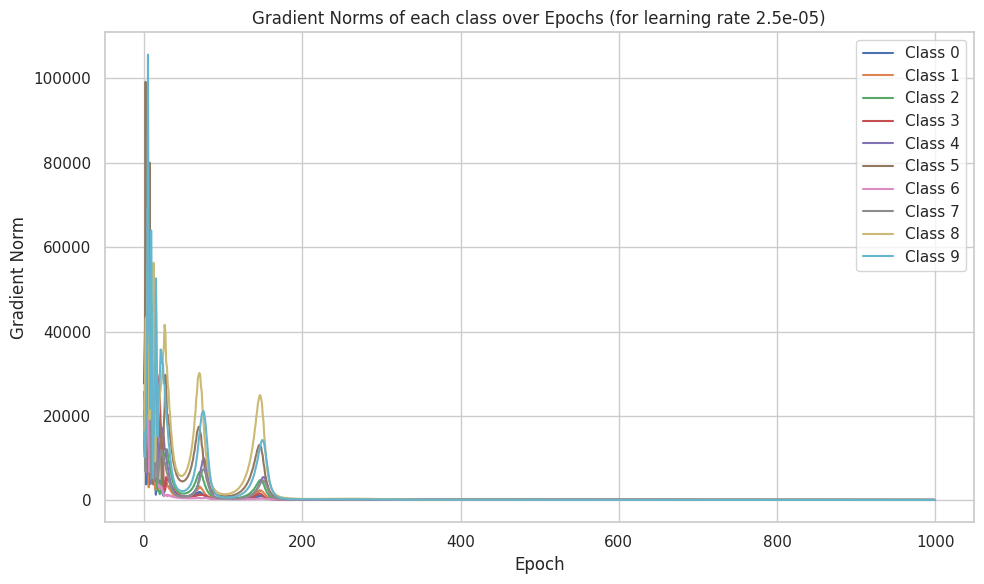

In [14]:
show_plot(grad_norms, 
          f"Gradient Norms of each class over Epochs (for learning rate {eta})", 
          "Gradient Norm")

In [15]:
softmax_confusion = inference_confusion_matrix(softmax_weights, x_test, y_test)
softmax_confusion

,0,1,2,3,4,5,6,7,8,9,Total
correct classifications,9910,9918,9818,9788,9861,9767,9906,9834,9779,9773,98354
incorrect classifications,90,82,182,212,139,233,94,166,221,227,1646
accuracy,0.991000,0.991800,0.981800,0.978800,0.986100,0.976700,0.990600,0.983400,0.977900,0.977300,0.983540
sensitivity,0.952233,0.974775,0.900000,0.887365,0.939583,0.871550,0.953893,0.921053,0.876858,0.892216,0.917700
selectivity,0.995131,0.993926,0.991091,0.989197,0.991040,0.987635,0.994570,0.990824,0.988408,0.986775,0.990856
number of samples,963,1110,1020,1021,960,942,976,1064,942,1002,10000


## Conclusions for Part B

### Convergence
From the generated graphs above we can see that, as expected, this algorithm takes bigger steps the further it is from the goal.  
This means that before the 1000th epoch, the model already reaches an accuracy within a margin of error of the final results, with the later epochs resulting in relatively small adjustments.  

By experimenting with the iteration limit value we can also see that it does benefit from longer runs,  
but at the speeds of a somewhat-modern home computer (let alone Google Colab) this reaches a point of diminishing returns very quickly.  
In one instance I have attempted to raise the iteration limit to 100,000 and saw an improvement in accuracy of less than 0.5%.
It's easy to imagine how with more specialized hardware (like GPUs) we can allow this algorithm (or even the former one) to achieve better results for roughly the same amount of time by allowing ourselves to perform the computational equivalent of penny-pinching. 

Given the right learning rate, we can see by looking at the graph that the function **does indeed seem to converge**,  
however it's hard to say if it really is converging on the absolute minimum or is converging to some value above the minimum.

### Learning Rate
The first immediate conclusion regarding learning rates is that fine-tuning makes a big difference. 
When the learning rate is too high the algorithm eventually gets stuck in place, undoing its own improvements.  
On the other hand, a learning rate that is too low would result in a very slow descent, which could only be compensated for with increasing the number of improvement iterations we perform during the training phase.  

By looking at the plot we can also see that a learning rate that starts out erratic can eventually stabilize, as is evident by the fact the spikes in the norm value become rarer and rarer.  

### Accuracy for each class 
Interestingly, the accuracy score we see for each class is very similar to that of the perceptron algorithm from part A.  
In fact, it seems the division to well-performing and poorly-performing classes is the same as it was in Part A.  
This suggests that **some classes are fundamentally easier or harder to recognize**, at least at the scope of linear models. 

### Comparison with The Perceptron algorithm from Part A 
A quick glance at the difference heatmap below shows that while the improvement to overall accuracy isn't very significant,  
we can see non-trivial improvement in the "problem children", that is, the classes we've seen to be relatively poor performers.  
However, these results come from models which are constrained by the fact that I want this whole notebook to start and finish running within a few minutes.  
By tuning the model limitations to be more generous we can improve the performance of either one and have them reach a performance difference even less significant than the one we see here.

At a very low iteration limit of 100 The perceptron algorithm's overall accuracy outpeforms the softmax algorithm by a little over 1%.  
With (relatively) many iterations we can see a non-trivial improvement in the amount of "problem classes" the model recognizes in both cases,  
however in the case of The Softmax algorithm that improvement seems to be more significant.  
Both of those differences are within margin of error and different divisions into training and test data, as well as the particular tuning of each model, may change who in particular is in the lead.


#### Softmax vs. Perceptron - confusion matrix difference heatmap

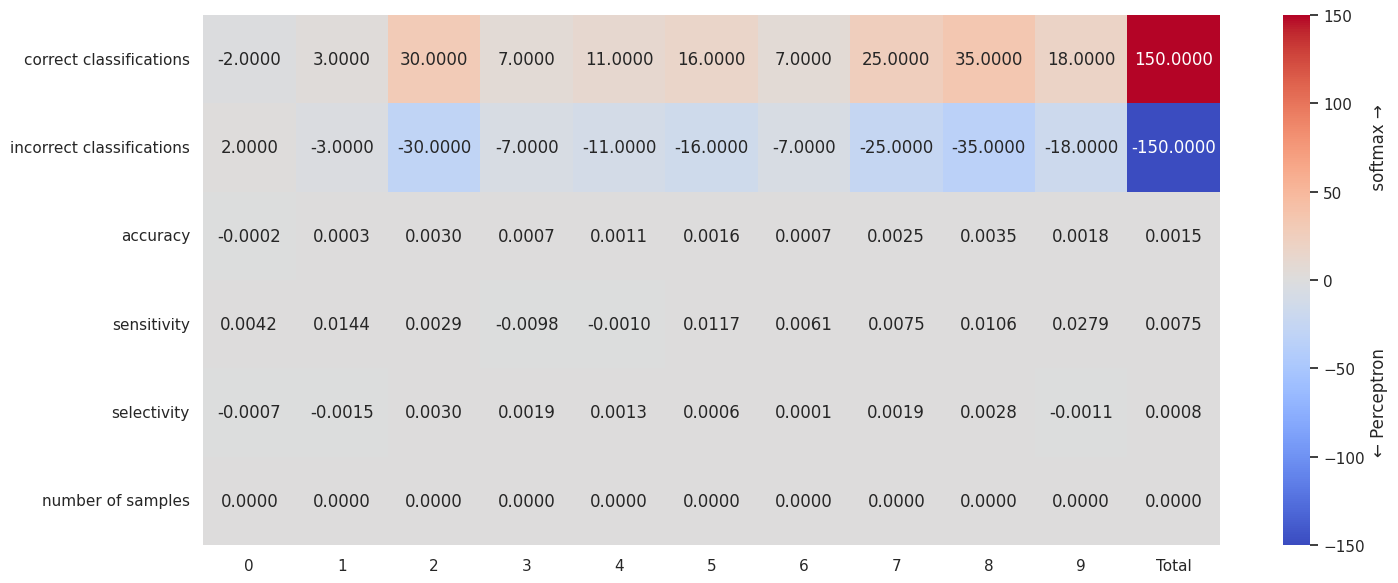

In [16]:
show_diff_heatmap(softmax_confusion, perceptron_confusion, 
                 "← Perceptron                              softmax →")

# Part C: Linear Regression

## Hypothesis

In this section we will apply Linear Regression to the problem via _least squares derivation_.  
The fundamental concept of the least squares derivation algorithm is that we want to find the following:
$$\underset{w \in \mathbb{R}^d}{\min} \; \overbrace{\frac{1}{N} \sum _{n=1} ^N (y_n - w^T x_n)^2}^{E_{in}(w)} = \underset{w \in \mathbb{R}^d}{\min} \left(  \frac{1}{N} ||y - Xw||^2 \right)$$
We want to _solve an equation_ for each class rather than perform some iterative adjustments.  
And just like in Part B, we can also extend it to working on several classes at once by simply using matrices of weights and labels, rather than vectors. 

Intiuitively, the features of a sample should be linearly independent, seeing as how the value of one pixel is not determined by that of its neighbors.  
After all, in any sample we can change the value for one feature (change one pixel) and that image wouldn't be "invalid".  

If these features are truly linearly independent, we can conclude that $X$ is a **full-rank matrix**.  
this means that $X^TX$ is an invertible matrix, which means $\left( X^TX \right) ^{-1}$ is _unique_ and that means that not only can we transform the normal equation $X^TXw=X^Ty$ into $w = \left( X^T X \right) ^{-1} X^T y$,  
But also that $w$ **has a unique solution**.  

The normal equation is an expression of when the gradient of $w$ equals 0, meaning this is a _stationary point_.  
The fact the normal equation has only one solution indicates that _there is only one stationary point_.  
Because the Hessian is $\nabla _w ^2 E_\text{in} (w) = \frac{2}{N}X^TX \succeq 0$, meaning it is semi-definite, we know the only stationary point is a local minimum.  

So if our intuitive assumption that the features are linearly independent is right, there should be one and only minimum point which we can find with the equation above.

## Implementation

In [17]:
def least_squares(x, y):

    first_half = np.linalg.pinv(x.T @ x)
    second_half = x.T @ y 
    return first_half @ second_half

def in_sample_error_least_squares(w, x, y):
    diff = np.square(y - (x @ w))
    return np.sum(diff, axis=0) / x.shape[0]

## Testing

In [18]:
weights_least_squares = least_squares(x_train, y_train)

error_least_squares = in_sample_error_least_squares(weights_least_squares, x_train, y_train)
pd.DataFrame({"in-sample error": error_least_squares}).T

,0,1,2,3,4,5,6,7,8,9
in-sample error,0.025294,0.029837,0.037032,0.043149,0.040073,0.045554,0.026375,0.033684,0.048029,0.049324


In [19]:
linear_confusion = inference_confusion_matrix(weights_least_squares.T, 
                                              x_test, y_test)
linear_confusion

,0,1,2,3,4,5,6,7,8,9,Total
correct classifications,9852,9720,9700,9636,9702,9630,9808,9692,9617,9613,96970
incorrect classifications,148,280,300,364,298,370,192,308,383,387,3030
accuracy,0.985200,0.972000,0.970000,0.963600,0.970200,0.963000,0.980800,0.969200,0.961700,0.961300,0.969700
sensitivity,0.950156,0.972973,0.803922,0.832517,0.892708,0.727176,0.909836,0.843045,0.736730,0.797405,0.848500
selectivity,0.988934,0.971879,0.988864,0.978505,0.978429,0.987525,0.988475,0.984221,0.985096,0.979551,0.983167
number of samples,963,1110,1020,1021,960,942,976,1064,942,1002,10000


## Conclusions for Part C

### Performance compared to the other models
The results we got do not fit our intuitive expectations.  
While the model's accuracy is entirely respectable, especially for something that is calculated near-instantaneously,  
it consistently performs poorly compared to the previous two models. (Assuming limits and the learning rate are set to reasonable values)  
The fact our Softmax model outperforms this model is of particular interest.  

### The features are NOT linearly-independent
If our intuitive hypothesis was true, then The Softmax model should have been converging onto the same point we just calculated here.  
Evidently this is not true because the softmax model converges on some "further minimum" than what we get here.  
Which implies **there is more than one minimum** in our target function, making Least-Square-Derivation-based Linear Regression a poor choice  
in all cases with the exception of extreme edge cases like being forced to get the best possible model using the fewest calculations possible.

The fact our features aren't linearly independent makes intuitive sense in retrospect.  
It's easy to imagine how removing any one of the pixels from the images in the dataset wouldn't make much of a difference in the case of hand-written digits.  
In truly handwritten digits the color of neighboring pixels usually changes in a gradual fashion rather than a sharp, abrupt one.  
Indeed, if we were given an image where one pixel didn't follow this rule-of-thumb, it would in all likelihood be an accidental mark left by the pen,  
a piece of dust that got between the camera and the figure or some other form of noise we'd do well to ignore.

## Problem-child classes
Here we seem to get confirmation that the "difficult" classes we saw in the previous two parts are, in fact, difficult and that our prior observations weren't a result of some coincidence.  
Interestingly, class 1 seems to perform very poorly here compared to the previous two models, in which class 1 was the best performing class.

### Confusion Matrix difference heatmaps

#### Linear Regression vs. Perceptron

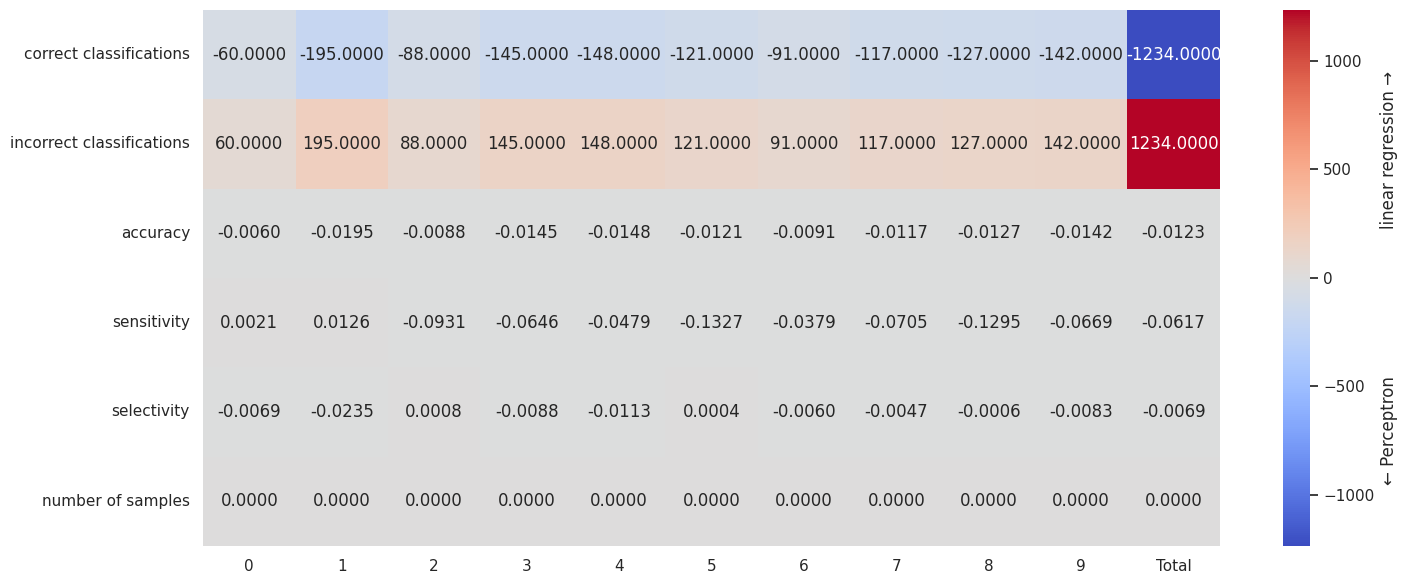

In [20]:
show_diff_heatmap(linear_confusion, perceptron_confusion, 
                 "← Perceptron                            linear regression →")

#### Linear Regression vs. Softmax

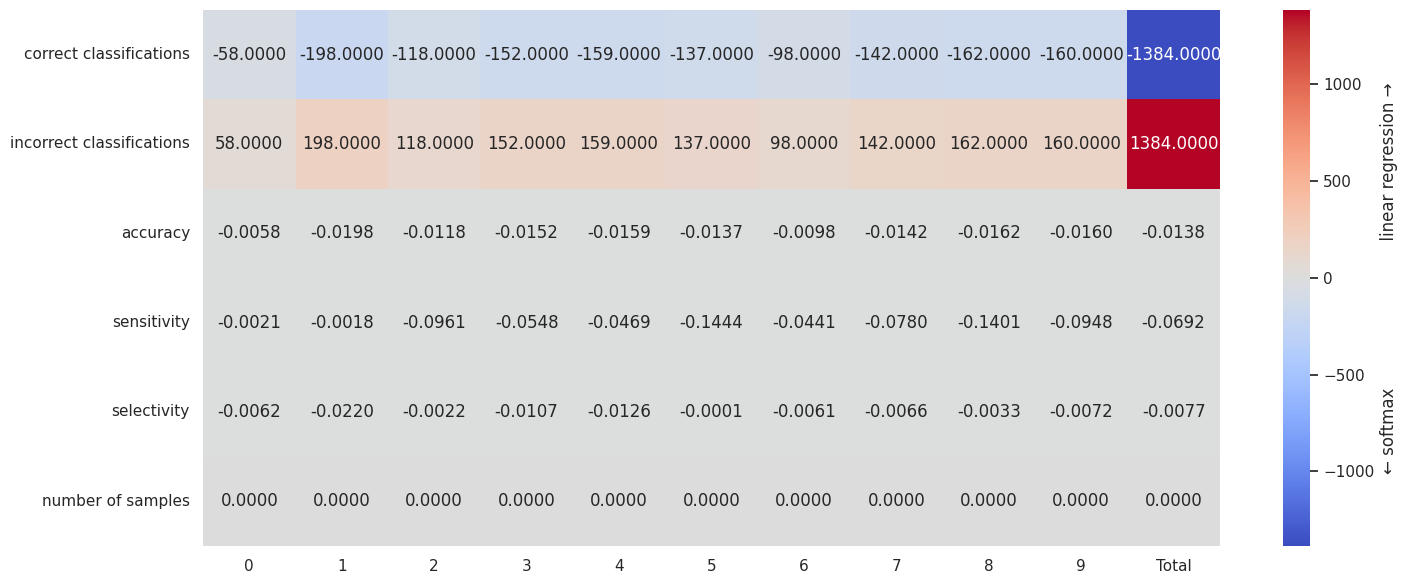

In [21]:
show_diff_heatmap(linear_confusion, softmax_confusion, 
                 "← softmax                            linear regression →")

**Closing remarks**:   
I have been working on this assignment (and ONLY this assignment) for a little over a week.  
In that time every dream I've had involved calculating dot products.  
Yes, really.  